## Assessment of meta-predictor in-silico tools and the variant functional classifier MITER in PPARG and further application to a HMBS dataset

### Installation

Recommend installing anaconda (instead of plain python) - most packages required below should be included. 

In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import xgboost as xgb 
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score


from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.model_selection import ShuffleSplit
import re
import random
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import seaborn as sns
import seaborn as sn

# Setup




In [3]:
def plot_confusion_matrix(cf_matrix,classes, y_true):
    """
    Plot confusion matrix given sklearn.metrics.confusion_matrix object
        
    """
    akws = {"ha": 'center',"va": 'center'}
    print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix, columns=classes, index = classes)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True)

Initialise tools

In [4]:
rf = RandomForestRegressor()
lr = LogisticRegression()
dt = tree.DecisionTreeClassifier()
svc = SVC()
gb = GradientBoostingClassifier(max_depth = 2, n_estimators=100)
xg = XGBClassifier(max_depth = 1, n_estimators=100)

### Read data

Read in three files 

* _full.csv_ is the PPARG ariants annotated with various in-silico tools (using pynnotator)
* _ClinPred_pparg_ is an additional annotation file not included in pynnatartor
* _desnick_full_ is the variants from the densick paper annoatated with pynnotator


In [5]:
df = pd.read_csv("full.csv", low_memory=False)
df_desnick = pd.read_csv("desnick_full.csv")
clinpred = pd.read_csv("ClinPred_pparg.txt", sep="\t")
df_desnick.loc[df_desnick.call == 'Pathogenic', 'pathogenicity'] = 'pathogenic'
df_desnick.loc[df_desnick.call == 'Benign', 'pathogenicity'] = 'not pathogenic'

**Cleanup data and merge in clinpred score**

We do not have a clinpred score for desnick variants due to time comstraints we shopuld probably get those 

In [6]:
df = df[~df['function_score'].isna()]

In [7]:
df = df.merge(clinpred, left_on=["chr", "hg19_pos", "ref", "alt"], right_on=['Chr', "Start", "Ref", "Alt"])

### Setup utilities to call regressors RF etc

In [8]:
def one_regressor(df, regressor, labels, y_label, description):
       X = df[labels]
       y = df[y_label]

       X_train, X_val, y_train, y_val = train_test_split(df[labels], y)
       regressor.fit(X_train, y_train)
       y_pred = regressor.predict(X_val)        
       r2 = r2_score(y_val, y_pred)
       print(f"{regressor.__class__.__name__} {labels}: {description} R2: {r2})")
       plt.scatter(df[labels[0]], df[y_label])

In [9]:
def regressor(df, regressor, label, inc=0.1):
    df = df .fillna(-1)
    i = 0
    while i < .99:
       sdf = df[(df[label] >= i) & (df[label] < (i + inc))]
       one_regressor(sdf, regressor, [label], "p_fpld3", f"{round(i, 2)}..{round(i + inc, 2)}")
       i = i + inc
    

In [10]:
def draw_roc_curve(classifier, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = classifier.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_probs)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()# plot the roc curve for the model


In [11]:
classes_map = {
 'not pathogenic': ["pathogenic", 'not pathogenic']   
}

In [12]:
def print_sensitivity_for_pvalue_cutoffs(y_val, y_pred, y_prob):
    print("cutoff,sensitivity,specfiticy") 
    for cutoff in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
       y_pred = [0 if p[0] > cutoff else 1 for p in y_prob]
       cnf_matrix = confusion_matrix(y_val, y_pred, normalize=None) 
       TP = cnf_matrix[0][0]
       FN = cnf_matrix[0][1]
       FP = cnf_matrix[1][0]
       TN = cnf_matrix[1][1]
       sensitivity = TP/(TP+FN) 
       specfiticy= TN/(TN+FP) 
       print(f"{cutoff},{round(sensitivity, 2)},{round(specfiticy, 2)}") 

In [13]:
def one_classifier(df, classifier, labels, y_label, silent = False, roc = False):
       df = df .fillna(0)
       X = df[labels]
       y_raw = df[y_label]
       if len(set(y_raw)) < 2:
        return
    
       le = preprocessing.LabelEncoder()
       le.fit(y_raw)
       y = le.transform(y_raw)

       X_train, X_val, y_train, y_val = train_test_split(df[labels], y)
       classifier.fit(X_train, y_train)
       y_pred = classifier.predict(X_val)        
       y_prob = classifier.predict_proba(X_val)        
        
       
       f1 = f1_score(y_val, y_pred, average=None)
       if roc:
        draw_roc_curve(classifier, X_val, y_val)
        
        
       if not silent: 
        
        
           cnf_matrix = confusion_matrix(y_val, y_pred, normalize=None)
            
           plot_confusion_matrix(cnf_matrix, classes_map[le.classes_[0]], y_val)
           cnf_matrix = confusion_matrix(y_val, y_pred, normalize='true')
           plot_confusion_matrix(cnf_matrix, classes_map[le.classes_[0]], y_val)
        
           print(f"{labels}: F1 score: {f1})")
           print(f"Labels: {sorted(set(y_raw))}") 
           plt.scatter(df[labels[0]], df[y_label])
            
           print_sensitivity_for_pvalue_cutoffs(y_val, y_pred, y_prob) 
  
       return (f1, le, classifier)


In [14]:
def classifier(df, classifier, label, y_label, inc=0.1):
    i = 0
    while i < .99:               
       sdf = df[(df[label] >= i) & (df[label] < (i + inc))]
       one_classifier(sdf, classifier, [label],y_label, f"{round(i, 2)}..{round(i + inc, 2)}") 
       i = i + inc


# Fix up data make it consistent

In [15]:
df.loc[~df['vep_Consequence'].isin(["missense_variant", "missense_variant&splice_region_variant", "start_lost", "synonymous_variant"]), "vep_Consequence"] = "UNKNOWN"
df.loc[~df['vep_IMPACT'].isin(["MODERATE", "UNKNOWN", "HIGH", "LOW"]), "vep_IMPACT"] = "UNKNOWN"
df_desnick.loc[~df_desnick['vep_Consequence'].isin(["missense_variant", "missense_variant&splice_region_variant", "start_lost", "synonymous_variant"]), "vep_Consequence"] = "UNKNOWN"
df_desnick.loc[~df_desnick['vep_IMPACT'].isin(["MODERATE", "UNKNOWN", "HIGH", "LOW"]), "vep_IMPACT"] = "UNKNOWN"


In [16]:
df['vep_CADD_phred'] = pd.to_numeric(df.vep_CADD_phred.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(float)
df_desnick['vep_CADD_phred'] = pd.to_numeric(df_desnick.vep_CADD_phred.astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(float)



### Utility function to fix up data from pynnatator - 

some valuers for example look like 1&1&1&2&1&1&3 representing an array of values we will get that array and take the mean for our purposes

In [17]:
def isFloat(string):
    try:
        f = float(string) 
        if f == float('inf') or  f == float('NaN'):
            return False          
        return True
    except ValueError:
        return False
    
def mean_of_scores(scores):
    tokens = str(scores).split("&")
    tokens = [0.0 if not isFloat(token) else token for token in tokens]
    nums = [float(token) for token in tokens]
    return np.mean(nums)

### Fix up the data

In [18]:
fields = ["vep_MutPred_score","vep_MutationAssessor_score","vep_MutationTaster_score","vep_PROVEAN_score","vep_Polyphen2_HDIV_score","vep_Polyphen2_HVAR_score", 
         "vep_DANN_score", 
"vep_FATHMM_score", 
"vep_GM12878_fitCons_score", 
"vep_GenoCanyon_score", 
"vep_H1-hESC_fitCons_score", 
"vep_HUVEC_fitCons_score", 
"vep_LRT_score", 
"vep_M-CAP_score", 
"vep_MetaLR_score",
"vep_MetaSVM_score",
"vep_MutPred_score",
"vep_MutationAssessor_score",
"vep_MutationTaster_score",
"vep_PROVEAN_score",
"vep_Polyphen2_HDIV_score",
"vep_Polyphen2_HVAR_score",
"vep_SIFT_score",
"vep_VEST3_score",
"vep_fathmm-MKL_coding_score",
"vep_integrated_fitCons_score",
]
for field in fields: 
    df[field] = df[field].apply(lambda x: mean_of_scores(x))
    df_desnick[field] = df_desnick[field].apply(lambda x: mean_of_scores(x))


### Encode string fields in the annotation as integers 

For "vep_Consequence", "vep_IMPACT" encode them as integers to be used by RF etc

In [19]:
def encode(values):
    le = preprocessing.LabelEncoder()
    le.fit(values)
    return le.transform(values)

encoding_required = ["vep_Consequence", "vep_IMPACT"]
df[encoding_required].fillna("UNKNOWN", inplace=True)
for field in encoding_required:  
    df[field + "_enc"] = encode(df[field])
    df_desnick[field + "_enc"] = encode(df_desnick[field])


/home/david.cotter/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


## Visualise linear relationship 

* revel vs function score 
* all scores vs function score

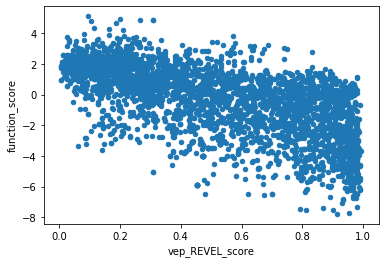

In [20]:
df[['vep_REVEL_score', 'function_score']].plot.scatter(x='vep_REVEL_score', y='function_score')

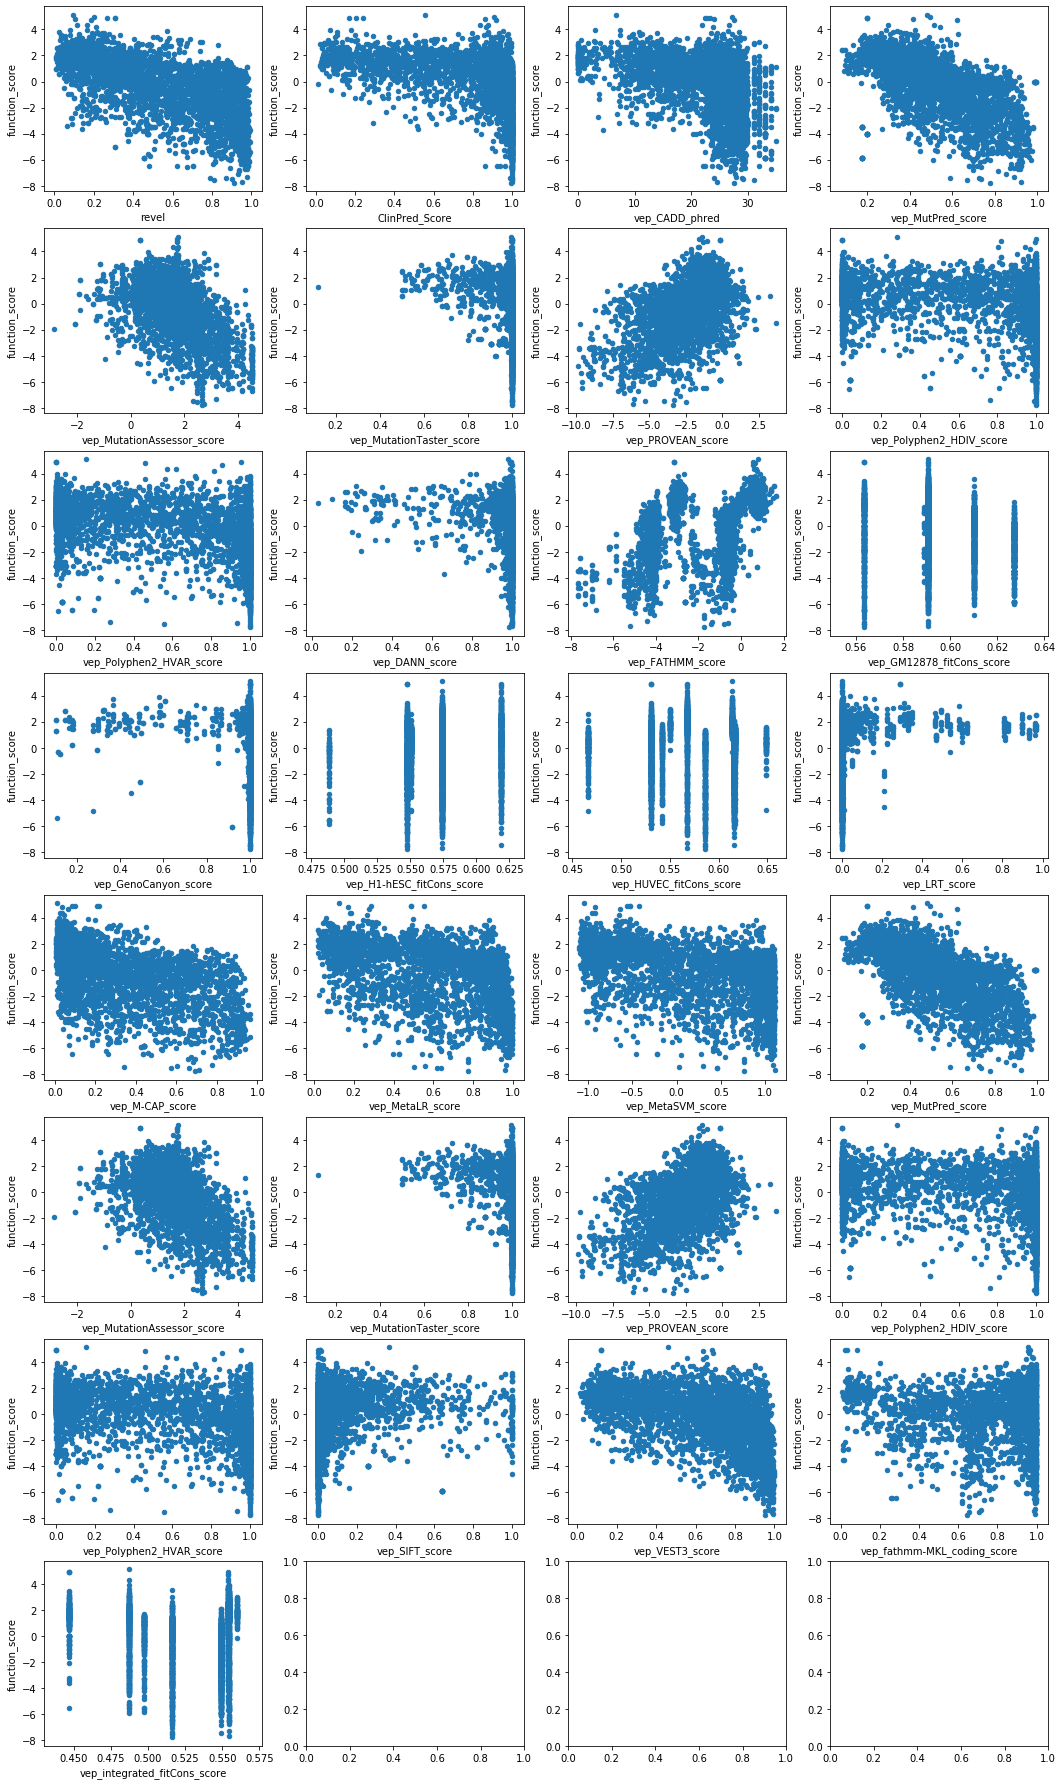

In [21]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
labels= ['revel', 'ClinPred_Score',  "vep_CADD_phred", 
"vep_MutPred_score",
         "vep_MutationAssessor_score",
         "vep_MutationTaster_score",
         "vep_PROVEAN_score",
         "vep_Polyphen2_HDIV_score",
         "vep_Polyphen2_HVAR_score", 
"vep_DANN_score", 
"vep_FATHMM_score", 
"vep_GM12878_fitCons_score", 
"vep_GenoCanyon_score", 
"vep_H1-hESC_fitCons_score", 
"vep_HUVEC_fitCons_score", 
"vep_LRT_score", 
"vep_M-CAP_score", 
"vep_MetaLR_score",
"vep_MetaSVM_score",
"vep_MutPred_score",
"vep_MutationAssessor_score",
"vep_MutationTaster_score",
"vep_PROVEAN_score",
"vep_Polyphen2_HDIV_score",
"vep_Polyphen2_HVAR_score",
"vep_SIFT_score",
"vep_VEST3_score",
"vep_fathmm-MKL_coding_score",
"vep_integrated_fitCons_score",
]
nrow=8
ncol=4
fig, axes = plt.subplots(nrow, ncol, figsize=(18, 32))
count=0
for r in range(nrow):
    for c in range(ncol):
      if count < len(labels): 
         df[[labels[count], 'function_score']].plot.scatter(x=labels[count], y='function_score', ax=axes[r,c])
      count += 1



### Linear regression revel vs function score

LinearRegression ['revel']:  R2: 0.41972890325544865)


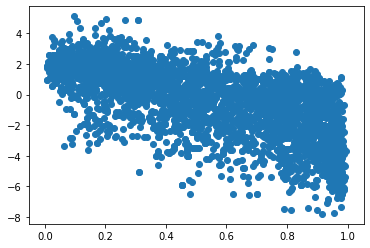

In [22]:
labels = ['revel']
df.fillna(0, inplace=True)
#labels=['revel']
one_regressor(df[(df.revel > 0) & (df.revel < 1)],  LinearRegression(), labels,"function_score", "")

### Dependentant variables
X is a list of dependant variables (x-valuies) input into the models. You can play with this list to see what results come out. For the ISHG poster I used just a few - that last line below with 

X=['vep_MutPred_score', 'vep_MutationAssessor_score', 'vep_MutationTaster_score',  "vep_CADD_phred", 

         "vep_PROVEAN_score",
         "vep_Polyphen2_HDIV_score",
         "vep_Polyphen2_HVAR_score"]

In [23]:
X= ['vep_REVEL_score',  "vep_CADD_phred", 
"vep_MutPred_score",
         "vep_MutationAssessor_score",
         "vep_MutationTaster_score",
         "vep_PROVEAN_score",
         "vep_Polyphen2_HDIV_score",
         "vep_Polyphen2_HVAR_score", 
"vep_DANN_score", 
"vep_FATHMM_score", 
"vep_GM12878_fitCons_score", 
"vep_GenoCanyon_score", 
"vep_H1-hESC_fitCons_score", 
"vep_HUVEC_fitCons_score", 
"vep_LRT_score", 
"vep_M-CAP_score", 
"vep_MetaLR_score",
"vep_MetaSVM_score",
"vep_MutPred_score",
"vep_MutationAssessor_score",
"vep_MutationTaster_score",
"vep_PROVEAN_score",
"vep_Polyphen2_HDIV_score",
"vep_Polyphen2_HVAR_score",
"vep_SIFT_score",
"vep_VEST3_score",
"vep_fathmm-MKL_coding_score",
"vep_integrated_fitCons_score",
]


X = ['vep_MutationTaster_score', 'vep_PROVEAN_score', 'vep_integrated_fitCons_score', 
     'vep_SIFT_score', 'vep_MutationAssessor_score', 'vep_Polyphen2_HVAR_score', 
     'vep_FATHMM_score']
X=['vep_MutPred_score', 'vep_MutationAssessor_score', 'vep_MutationTaster_score',  "vep_CADD_phred", 

         "vep_PROVEAN_score",
         "vep_Polyphen2_HDIV_score",
         "vep_Polyphen2_HVAR_score"]


## Models

* LogisticRegression vep_REVEL_score vs prediction_fpld3

No handles with labels found to put in legend.


ROC AUC=0.834


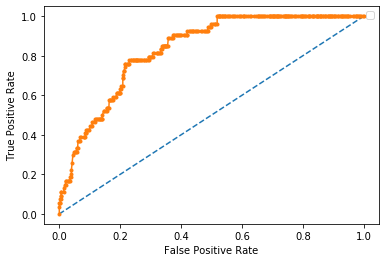

[[576 253]
 [ 11  43]]
[[0.69481303 0.30518697]
 [0.2037037  0.7962963 ]]
['vep_REVEL_score']: F1 score: [0.81355932 0.24571429])
Labels: ['not pathogenic', 'pathogenic']
cutoff,sensitivity,specfiticy
0.1,1.0,0.0
0.2,0.97,0.17
0.3,0.85,0.52
0.4,0.77,0.76
0.5,0.69,0.8
0.6,0.63,0.89
0.7,0.57,0.93
0.8,0.5,0.96
0.9,0.37,1.0
0.95,0.21,1.0


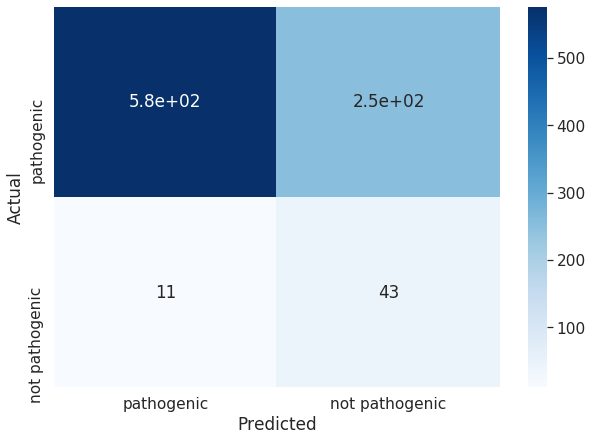

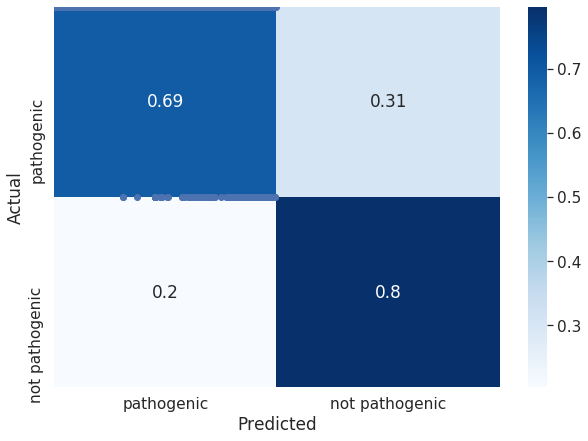

In [24]:
f1, le, classifier = one_classifier(df, LogisticRegression(solver='lbfgs', class_weight="balanced"), ['vep_REVEL_score'],"prediction_fpld3",  silent=False, roc=True)

### Models

LogisticRegression list of in-silico tools (X)  vs prediction_fpld3

In [ ]:
f1, le, classifier = one_classifier(df, LogisticRegression(solver='lbfgs',  class_weight={0:1.0, 1:50.0}),   X,"prediction_fpld3", silent=False, roc=True)


/home/david.cotter/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
No handles with labels found to put in legend.


### Models

How does the model perform on the not-seen-before desnick variants

In [ ]:
df_desnick = df_desnick.fillna(0)
y_pred = classifier.predict(df_desnick[X])        
y_prob = classifier.predict_proba(df_desnick[X]) 
print_sensitivity_for_pvalue_cutoffs([(1 if x == 'Pathogenic' else 0)for x in df_desnick['call']], y_pred, y_prob)

## Models 
RandomForestClassifier vep_REVEL_score vs prediction_fpld3

In [ ]:
one_classifier(df, RandomForestClassifier(n_estimators=300, class_weight="balanced"), ['vep_REVEL_score'],"prediction_fpld3", silent=False, roc=True)

## Models 
RandomForestClassifier in-silico combo (X)  vs prediction_fpld3

In [ ]:
f1, le, classifier = one_classifier(df, RandomForestClassifier(n_estimators=300, class_weight="balanced"), X,"prediction_fpld3",  silent=False, roc=True)

### Models

How does the model perform on the not-seen-before desnick variants

In [ ]:
df_desnick = df_desnick.fillna(0)
y_pred = classifier.predict(df_desnick[X])        
y_prob = classifier.predict_proba(df_desnick[X]) 
print_sensitivity_for_pvalue_cutoffs([(1 if x == 'Pathogenic' else 0)for x in df_desnick['call']], y_pred, y_prob)

# Some stats

In [ ]:
df = df.fillna(0)
exog =  sm.add_constant(df['vep_REVEL_score'], prepend=False)

In [ ]:
exog

In [ ]:
stats.spearmanr(df.function_score, df['vep_MutPred_score'])

In [ ]:
stats.pearsonr(df.function_score, df['revel'])

In [ ]:
mod = sm.OLS(df.function_score, sm.add_constant(df['vep_REVEL_score'], prepend=False))

In [ ]:
res = mod.fit()

In [ ]:
res.resid.hist()

In [ ]:
print(res.summary())

In [ ]:
res.summary()